# Projecting EV Usage Across U.S. Counties and Into the Future
**ENERES 131; Fall 2020**

1. Ciara Dorsay - Ridge Regression
2. Samay Garg - Random Forest
3. Rohit Rungta - Linear Regression

**Github Repository:** https://github.com/samaygarg/evprediction

In [20]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
from urllib.request import urlopen
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image, display

In [21]:
pd.set_option('display.max_columns', None)

In [22]:
from matplotlib import rcParams
# figure properties
rcParams['figure.figsize'] = (6,4)
rcParams['figure.dpi'] = 150
rcParams['savefig.dpi'] = 300
rcParams['savefig.bbox'] = 'tight'
# tick styling
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['xtick.bottom'] = True
rcParams['ytick.left'] = True
rcParams['ytick.right'] = True
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
#legend styling
rcParams['legend.fancybox'] = False
rcParams['legend.edgecolor'] = 'k'
rcParams['legend.fontsize'] = 10
# line styling
rcParams['lines.linewidth'] = 1.5
rcParams['errorbar.capsize'] = 3
rcParams['lines.markersize'] = 3
# text styling
rcParams['mathtext.default'] = 'regular'
rcParams['axes.labelsize'] = 10
rcParams['axes.titlesize'] = 14
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 10

cmap_default = 'twilight_shifted'

In [23]:
dataurl = 'https://raw.githubusercontent.com/samaygarg/evprediction/main/data/clean/masterdata.csv?token=AOMIPUBEUNFUCVT2NIL24HC74E4UE'
dataurl_allcounties = 'https://raw.githubusercontent.com/samaygarg/evprediction/main/data/clean/masterdata_allcounties.csv?token=AOMIPUCP6DQ3OHKKE4SFNQC74E4YC'
timedataurl = 'https://raw.githubusercontent.com/samaygarg/evprediction/main/data/clean/temporaldata.csv?token=AOMIPUEQT2JIPOSWD2LHGSK74FFOS'
timedataurl_allcounties = 'https://raw.githubusercontent.com/samaygarg/evprediction/main/data/clean/temporaldata_allcounties.csv?token=AOMIPUEIBRW54GHQDNYS2W274FFQS'

## Abstract

$\;\;\;\;\;\;$Electric vehicles (EVs) are becoming an increasingly attractive alternative to traditional vehicles. Now available from a range of manufacturers at more affordable prices, many countries, especially the United States, appear to be on the cusp of a wave of EV adoptions. Understanding and predicting where and when these major adoptions will occur is essential to building the infrastructure needed to support and further encourage the growth of this sector of transportation. While previous studies have been conducted to predict variables like electrical power load from EV charging stations, few have looked at attempting to predict the actual number of EVs in both space and time. One of the primary obstacles in solving this problem is simply the lack of data; existing EV registration data is sparse, inconsistent, and potentially unreliable, increasing the need to make these kinds of predictions. We attempted to address this problem by first beginning with three different models to predict registered EVs across counties in the United States: a linear regression model, a ridge regression model, and a decision tree/random forest model. We compared the test mean squared error values across the different models after conducting cross validation to select the best model (test MSE linear regression = 4.67e-05,test MSE ridge = 4.98e-05, test MSE random forest = 2.40e-05). While a different problem, we found the random forest to be best suited to handling our features from the spatial problem and applied it to the temporal issue. The results from applying the random forest model to our problem showed that regions near the coasts, especially New York, should currently have some of the highest rates of EV adoption (number of registered EVs). 

## Project Background

$\;\;\;\;\;\;$There are several types of electric vehicles (EVs) currently available: battery electric vehicles (BEV), fuel cell electric vehicles (FCEV), plug-in hybrid electric vehicles (PHEV), and hybrid electric vehicles (HEV).<sup>[1](https://www.evgo.com/why-evs/types-of-electric-vehicles/)</sup> Since the arrival of the first mass-produced hybrid car, the Toyota Prius, around the entire world in 2000, sales of EVs have gained increasing popularity.<sup>[2](https://www.energy.gov/articles/history-electric-car)</sup> 

$\;\;\;\;\;\;$EVs offer an appealing alternative to traditional gasoline/diesel dependent vehicles that are responsible for greatly contributing to a notable greenhouse gas: carbon dioxide.<sup>[3](https://reader.elsevier.com/reader/sd/pii/S1361920914001515?token=2831087B3E9AC57F3842947FA80CF757CDE3032188B488572015E96ADC53FBC6120453E7ACE0EF0116C869CFB1D0E05B)</sup> However, this increase has not been (a) homogeneous across the world or the United States and (b) has not been large in magnitude in general. One argument that has been made to account for relatively low levels of EV adoption is that consumers in the United States might have a poor perception of them, or at least perceive the cons to outweigh the cons of purchasing such a vehicle.<sup>[3](https://reader.elsevier.com/reader/sd/pii/S1361920914001515?token=2831087B3E9AC57F3842947FA80CF757CDE3032188B488572015E96ADC53FBC6120453E7ACE0EF0116C869CFB1D0E05B)</sup> Several factors that could affect consumers’ perception are strongly tied to current habits and the idea that electric vehicles are a car of the future, not the present.<sup>[3](https://reader.elsevier.com/reader/sd/pii/S1361920914001515?token=2831087B3E9AC57F3842947FA80CF757CDE3032188B488572015E96ADC53FBC6120453E7ACE0EF0116C869CFB1D0E05B)</sup> An older study published of a survey conducted in 2010 in Ireland looked at individuals’ preferences for different electric vehicles available at the time.<sup>[4](https://www.sciencedirect.com/science/article/abs/pii/S0967070X10000545?via%3Dihub)</sup> The paper found that vehicle reliability, safety, current fuel prices, and costs associated with ownership were rated most highly in preferences for EVs. While some of these variables can be easily accounted for in a prediction problem in terms of ease of obtaining a reliable, robust dataset, that is not the case for all of them. Vehicle reliability is a difficult quality to quantify. We were also not interested in differentiating between particular EV models, which would capture vehicle safety. Instead, the focus of our project was to approach two prediction problems; the first to predict the number of registered EVs in different counties where no record of such a number existed for a given year (focused on 2017), and the second was to predict the number of registered EVs some amount of time (two years) into the future. 

$\;\;\;\;\;\;$The need to address the first problem stems from the fact that registered EV data across the United States is sparse and inconsistent. From our initial data exploration, we discovered only a single dataset containing this information from fifteen states (which we used to train our models). States/counties that do not collect EV registration data are further hindering the adoption of additional EVs, as without adequate data, those regions are unable to determine current or future EV usage. Thus, they cannot begin developing the infrastructure needed to support them and encourage their use, which brings us to the necessity to address our second prediction question. As such, our goal with this project was to address these spatial and temporal data gaps by capturing several societal and economic factors that could have a relationship and predict the number of EVs registered by county. 

1.     Types of Electric Vehicles: BEV, PHEV, and HEV. <em>EVgo</em> (2020).
2.   The history of the electric car. <em>Energy.gov</em> (2020).
3.     Rezvani, Zeinab & Jansson, Johan & Bodin, Jan. Advances in consumer electric vehicle adoption research: A Review and research agenda. Transportation Research Part D: Transport and Environment 34, 122-136 (2015). 
4.    Caulfield, Brian & Farrell, Seona & McMahon, Brian. Examining individuals preferences for hybrid electric and alternatively fueled vehicles. Transport Policy 17, 381-387 (2010).

## Project Objective

Predition Problems:
1. Predict the EV usage in counties within states for which no such data currently exists
2. Predict the EV usage across different U.S. counties in 2021 and 2022.

Resource Allocation Problems:
1. Temporally and spatially predicting EV usage will help leaders to decide:
2. When and where to invest in EV infrastructure
3. How much to invest in EV infrastructure
4. Best policies or incentives to promote EV usage


## Input Data Description

$\;\;\;\;\;\;$The data used in this study was obtained from four different sources: [The U.S. Census Bureau](https://data.census.gov/cedsci/), [The U.S. Department of Energy Alternative Fuels Data Center](https://afdc.energy.gov/), [The U.S. Energy Information Administration](https://www.eia.gov/), and [The Altas EV Hub](https://www.atlasevhub.com/).

$\;\;\;\;\;\;$**U.S. Census Bureau:** The U.S. Census Bureau was used to collect demographic information regarding each county. Particularly, we downloaded data regarding the education level, income levels, total population, housing types, and commute times. The data was downloaded directly from the U.S. Census website as CSV files. 5-year American Community Survey (ACS) estimates were used for all Census data. The 5-year estimates are collected over a period of time, which results in the increased statistical reliability of the data - especially in less populated areas.<sup>[1](https://www.census.gov/data/developers/data-sets/acs-5year.html#:~:text=The%205%2Dyear%20estimates%20from,areas%20and%20small%20population%20subgroups.)</sup> The granularity of the data is on a county basis (each row in the table represents one county in the U.S.). Demographic data were downloaded for each county in the U.S. between the years of 2013-2018. The data from the Census is quite trustworthy as it is collected and published directly by the U.S. government; however, even with the most accurate 5-year ACS surveys there are uncertainties associated with each measurement. Additionally, the presence of systematic biases the survey collection method often leads to the overcounting of undercounting of certain subpopulations.<sup>[2](https://censuscounts.org/whats-at-stake/census-accuracy-and-the-undercount-why-it-matters-how-its-measured/)</sup>

$\;\;\;\;\;\;$**DOE Alternative Fuels Data Center:** The DOE Alternative Fuels Data Center was used to download data regarding the history of gas and electricity prices and federal incentives towards owning electric vehicles from 2013-2019. Although all of the data was downloaded from the DOE’s website, the data itself was gathered from various sources. The gas prices were compiled from the monthly Clean Cities Alternative Fuel Price [Reports](https://afdc.energy.gov/publications/search/keyword/?q=alternative%20fuel%20price%20report), while the electricity prices were compiled from the U.S. Energy Information Administration’s [Energy Outlook](https://www.eia.gov/outlooks/steo/data/browser/#?v=21). The history of the federal incentives was compiled from the National Renewable Energy Laboratory (NREL) database. All of these data were at a federal (entire U.S.) granularity. Thus, this data was used in the temporal predictions, rather than the spatial predictions. Since all of the data were aggregated from official U.S. government agencies, it is expected to be quite trustworthy. Some manipulations were conducted to deal with minor inconsistencies, which are further explained in the Data Cleaning Section.   

$\;\;\;\;\;\;$**U.S. Energy Information Administration:** The U.S. Energy Information Administration (EIA) was used to download the per-capita energy related CO<sub>2</sub> emissions for each state in the U.S. between 2010-2016. This data was generated, compiled, and published in a report published by the EIA.<sup>[3](https://www.eia.gov/environment/emissions/state/analysis/pdf/stateanalysis.pdf)</sup> Since the per-capita CO<sub>2</sub> emissions were not available at the county level, a state’s CO<sub>2</sub> emissions level was applied to all of the counties within the given state. Again, since the data was collected and published by an official U.S. governmental agency, it can be trusted to be credible. Due to the interconnected nature of the energy industry, some simplifying assumptions were made by the EIA. For example, all biomass that was used by industries and homes were assumed to be carbon neutral. The full and comprehensive methodology can be found directly in the [report](https://www.eia.gov/environment/emissions/state/analysis/pdf/stateanalysis.pdf).  

$\;\;\;\;\;\;$**Atlas EV Hub:** The Atlas EV Hub was used to download the target variable: the number of registered EV’s in a given county. Although many states have individual databases of registered electric vehicles, there is not a centralized location where all EVs in the U.S. are recorded in a singular database. The Atlas EV Hub attempts to solve this problem, by combining published EV data from individual states. This data is provided at a county granularity and dates back to 2010. Due to the lack of published data in many states, the Atlas EV Hub only publishes data for 15 states. A list of these states along with their data source/partner can be found directly on their [website](https://www.atlasevhub.com/materials/state-ev-registration-data/#data). Although all of the data source partners are with state-level governmental agencies, there are often inconsistencies in the way in which different states record their data. The largest issue is that many states are not able to provide vehicle registration data frequently enough to understand how the EV market has been changing over time. We are, however, able to use the data to analyze the total number of registered EVs in a state on a yearly basis. 

$\;\;\;\;\;\;$An example of the combined dataset is shown below. The '# of EVs' column was sourced from the Atlas EV Hub, the 'Per Capita CO<sub>2</sub>' column was sourced from the EIA, and all other features were sourced from the U.S. Census Bureau. Please refer to the Data Cleaning section to understand how the data was manipulated and merged to create the following table.

In [24]:
masterdf = pd.read_csv(dataurl)
masterdf = masterdf.rename(columns={'count': '# of EVs'})
masterdf.head()

,"9th to 12th grade, no diploma",high school graduate (includes equivalency),"some college, no degree",associate's degree,bachelor's degree,graduate or professional degree,year,fips,geographic area name,median income (family),median income (nonfamily),total population,occupied housing units,"1-unit, attached",2 units,3 or 4 units,5 to 9 units,10 to 19 units,20 or more units,mobile home,"boat, rv, van, etc.",commute time,co2_conc,# of EVs,state
0,6.6,20.3,18.4,6.9,24.0,16.3,2010,6001,"Alameda County, California",85014.0,44439.0,1477980,532026,8.242266,4.516133,7.746238,6.190675,5.983918,16.833576,1.344671,0.115032,12.456474,9.671581,20,CA
1,9.8,30.5,28.5,9.5,13.2,5.8,2010,6005,"Amador County, California",65103.0,33411.0,38327,14715,3.533809,2.324159,2.154264,0.767924,1.230037,2.657153,9.113150,0.013592,9.893939,9.671581,1,CA
2,5.9,19.7,22.3,8.2,24.5,13.7,2010,6013,"Contra Costa County, California",91791.0,47627.0,1024809,368087,8.502881,2.053047,5.690774,5.219690,3.747755,8.936203,1.937314,0.062757,13.799532,9.671581,10,CA
3,10.8,23.2,22.6,7.6,13.4,6.3,2010,6019,"Fresno County, California",52306.0,28843.0,908830,283836,2.584943,3.393157,8.102919,8.195578,2.956637,5.566242,4.951451,0.144450,8.000660,9.671581,2,CA
4,6.4,26.0,29.3,8.8,17.7,8.6,2010,6023,"Humboldt County, California",53221.0,24568.0,133058,54276,3.758567,4.875083,6.387722,4.355516,2.546245,3.080551,10.761663,0.287420,7.378587,9.671581,2,CA


1. American Community Survey 5-Year Data (2009-2019). <em>United States Census Bureau</em> (2020).
2. Census Accuracy and The Undercount: Why It Matters; How It’s Measured. <em>Census Counts</em> (2020).

## Data Cleaning

Despite all of the data coming from government maintained databases, each data source provided its own challenges in the data cleaning process. The data cleaning process is addressed separately for each of our individual sources below.  

**U.S. Census Bureau:**

<u>Education Data</u><br>
$\;\;\;\;\;\;$This dataset included both estimates of actual values in the columns (e.g. ‘Less than high school graduate’, ‘High school graduate’), as well as margins of error. We were not interested in incorporating margins of error into our prediction problem, as this would have introduced a range of complications to account for in our model design and selection process. In addition, many of the other datasets we included in our project from other sources did not include margins of error, and so we wanted to homogenize our features in this way. As such, only estimates were retained. The original dataset also had column headers that were not easily identifiable as far as the information included below them. As such, they were removed. There were additional headers provided below these initial headers that provided more specific information (e.g. strings of informative words rather than numerical/alphabetical code). These particular headers were also modified to get rid of unnecessary punctuation/words (e.g. ‘!!’, ‘Total’). The original datasets were also separated by state; these datasets were concatenated to produce one entire education dataset. Also, in some states the education data were listed as percentages of the total population, while in others it was simply the number of individuals. As such, for those states, education data was normalized by the total population to homogenize this particular feature data. 

<u>Income Data</u><br>
$\;\;\;\;\;\;$The steps and motivations listed in the “Education Data” section above will be repeated to some degree in all of the following sections, as each of these datasets are from the same source. One of the differences for the income data, however, is that in addition to not being interested in margins, in certain breakdowns of demographic data that were included in this dataset, for example, by race/ethnicity. Instead we were interested in median income data by household and for non-family households. The headers had similar issues to “Education Data”, so extra punctuation and inconsistent capitalizations had to be taken care of. There were also many additional subsets of income data, which had to be concatenated in the end. In addition, once we began working with the data, there were several entries that were recorded as ‘-’, which we assumed meant missing values. As such, we removed those entries from the dataset; setting them to zero would not have made sense because it is highly unlikely that everyone living in a given county had an income of $0. 
 
<u>Housing Data</u><br>
$\;\;\;\;\;\;$We were interested in all of the housing data from the Census datasets. As such, only margins were excluded. The column names also had to be modified to correct punctuation and inconsistent capitalizations. There were also many missing values for the different types of housing and number of units; for these cases we assumed the value to be 0. While a range of values could still be possible for these cases, the likelihood of the value being zero seemed to be much greater. For example, if the value was missing for a county for the ‘Boats’ column, most likely no boats were owned in that region. 

<u>Commute Data</u><br>
$\;\;\;\;\;\;$We were only interested in aggregate travel time to work in minutes. We thought that records capturing this information in terms of time rather than distance best accounted for differences in travel distance overcome by alternate means of transportation (e.g. public transportation such as subway, buses, etc.). This data is also an aggregate (i.e. summed over all individuals in a county who responded); as such, before the final concatenation this value was divided by the total population in a given record. 

<u>Population Data</u><br>
$\;\;\;\;\;\;$We were only interested in estimates of total population data for this dataset. The different datasets of split up regions also had to be concatenated in the end. 

**U.S. Energy Information Administration**:

<u>Per Capita CO<sub>2</sub></u><br>
$\;\;\;\;\;\;$This was the only data to come from this source. It was also initially downloaded as a .xlsx file, so the primary changes were made in Excel. The spatial resolution of the data was coarser than most of our other features (state vs. FIPS/county), and only one value was recorded for each state for each year 1990-2017, so it was relatively easy to address any concerns upon visual inspection. The cleaning that needed to be performed on this dataset included eliminating four change over time columns (1990-2017, 2016-2017 in percent and absolute change), as well as eliminating several rows of empty space/overall dataset information (e.g. table title and units of the recorded values). In addition, once the data was loaded in and merged with the overall feature matrix, several values were missing. We decided to remove these entries from the overall feature matrix because we could not appropriately assume a different value to attribute to the locations associated with the missing values. 

**Atlas EV Hub**

<u>Number of EVs</u><br>
$\;\;\;\;\;\;$From this source we pulled information for our target variable, number of registered EVs in each county, for 15 different states. However, the source of our data pulled the data provided on their website from individual state governments, which each proved to have different data record practices. First, all cases had registered EVs recorded by zip code/county/county geoid. This data was then passed through a function to count all of the EV records in a given zip code/county/county geoid in each state. Then functions were performed to homogenize the columns across the different states to end up with a final product containing ‘count’, ‘county’, ‘county geoid’, ‘model year’, ‘registration year’, and ‘state’. Then the data from all fifteen states were concatenated into a single dataframe. We then used a dataset of zip codes with their corresponding Federal Information Processing Standard (FIPS) code, which uniquely identify geographic areas. This was done to make sure we were able to correctly identify the state in which records of vehicle counts belonged. We also performed this process for the other data, especially the data from the Census. Finally, we ran into a problem where about 100 entries where the states from Atlas Hub did not match up with the states from the Census. For these entries, we considered throwing the data out, but upon further inspection we realized that the data itself was not from the respective DMVs. Instead, they appeared to come from different energy offices and so it was unclear exactly how the information was collected. One potential, likely reason is that the discrepancies arose from people registering their vehicles in one state, but then driving them/living in another. We made the decision to then attribute all of these entries with the associated Census state. 

**Data Cleaning (General) - Bringing Everything Together**

$\;\;\;\;\;\;$Once we had our individual datasets cleaned and organized, we dropped excess columns (e.g. ‘id’, ‘geographic name’). We then went on to merge all of the datasets together, starting from the top and performing an inner join on each set. We merged on two features: ‘fips’ and ‘year’. We then ran into the issue of two columns, median income for families and median income for nonfamilies, being recorded as strings rather than floats, so these values were converted to floats. To include the carbon dioxide emissions data, we merged on ‘year’ and ‘state’ because this data was recorded on a state, rather than county, level. 



## Data Summary and Exploratory Data Analysis

In [25]:
masterdata = pd.read_csv(dataurl)

In [26]:
def make_scatter(df, xcol, ycol='count', ax=None, fig=None):
    if ax is None:
        fig, ax = plt.subplots()
    xdata = stats.zscore(df[xcol].values, nan_policy='omit')
    ydata = df[ycol]
    if ycol == 'count':
         ydata / df['total population']*1000
    ax.scatter(xdata, ydata / df['total population']*1000)
    return fig, ax

Scatter plots showing the relationship between  the number of electric vehicles registered per 1000 people and several selected predictor variables are shown below. There does appear to be a positive correlation between these variables and the response variable, albeit a fairly weak one. Although the correlation appears to be weak, we believe that either careful feature engineering of the use of modelling frameworks which are well suited to highly irregular data will allow us to elucidate relationships between the chosen economic and demographic features and EV adoption which may not be readily apparent.

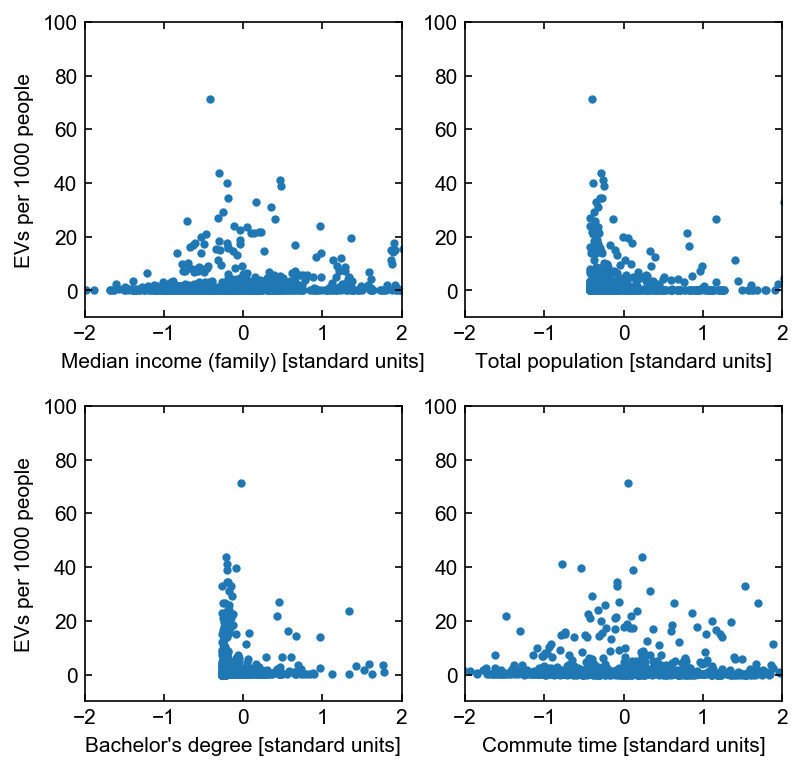

In [27]:
data_2017 = masterdata[masterdata['year'] == 2017]
cols_todrop = ['year', 'fips', 'state', 'geographic area name', 'boat, rv, van, etc.', '1-unit, attached']
data_2017 = data_2017.drop(columns=cols_todrop)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6,6), gridspec_kw={'hspace':0.3})
cols_tovis = ['median income (family)', 'total population', "bachelor's degree", 'commute time']
for thisax, thiscol in zip(ax.flatten(), cols_tovis):
    make_scatter(data_2017, thiscol, ax=thisax)
    thisax.set_ylim(-10,100)
    thisax.set_xlim(-2,2)
    thisax.set_xlabel(thiscol.capitalize() + ' [standard units]')
ax[0,0].set_ylabel('EVs per 1000 people')
ax[1,0].set_ylabel('EVs per 1000 people');

The heatmap below shows the correlation between different variables. For the most part, the features do not appear to be correlated with each other; however, there does appear to be a high degree of correlation between the education variables.  **Will add something here**

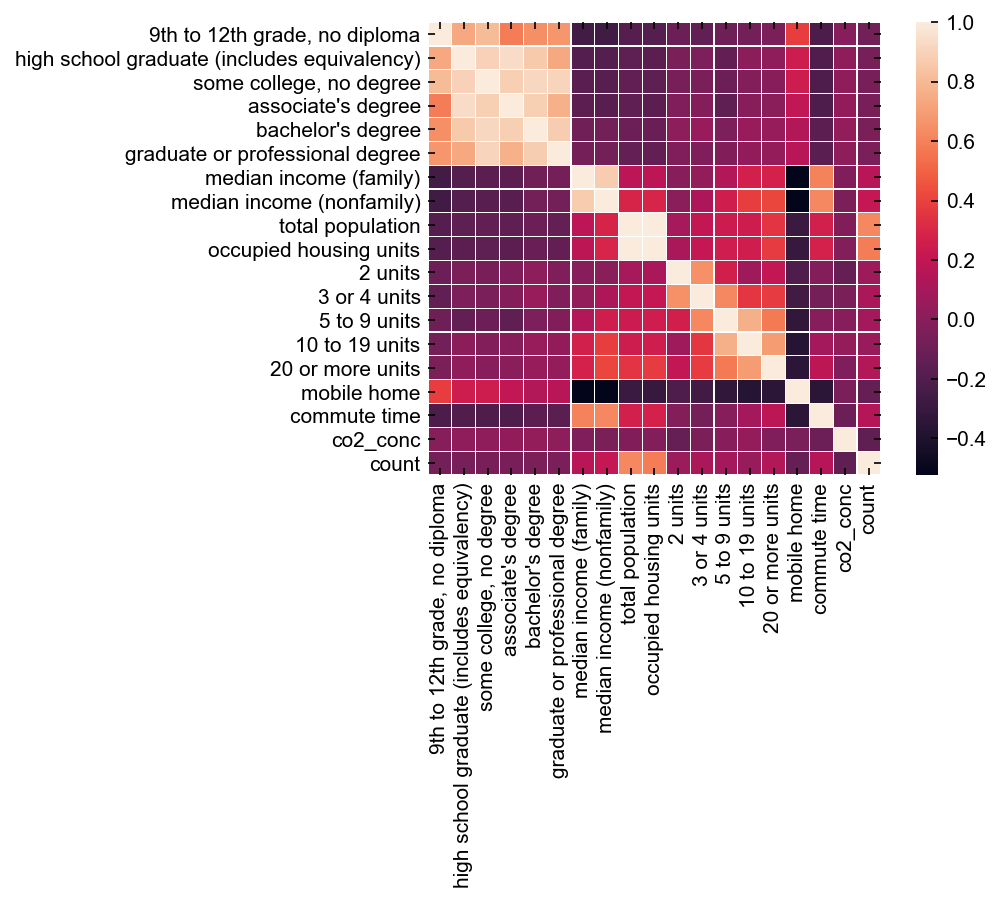

In [10]:
sns.heatmap(data_2017.corr(), square=True, linewidths=0.1);

## Forecasting and Prediction Modeling

**Linear Regression**<br>
$\;\;\;\;\;\;$We started out with linear regression to get a baseline model. This would expand upon our EDA analysis and give us a better sense of what feature variables are the strongest predictors of EV registration in a given county. Due to the lack of hyperparameters in simple linear regression, no cross-validation was needed. Upon splitting the data on a 70/30 test/train split, the resulting model had a testing mean squared error (MSE) of $4.67\cdot10^{-5}$. The plot below shows that there seems to be a significant amount of bias in the model. Additionally, the features that are seemingly the best predictors are the county's population and education level. Highly educated populations tend to result in increased EV adoption rates. 

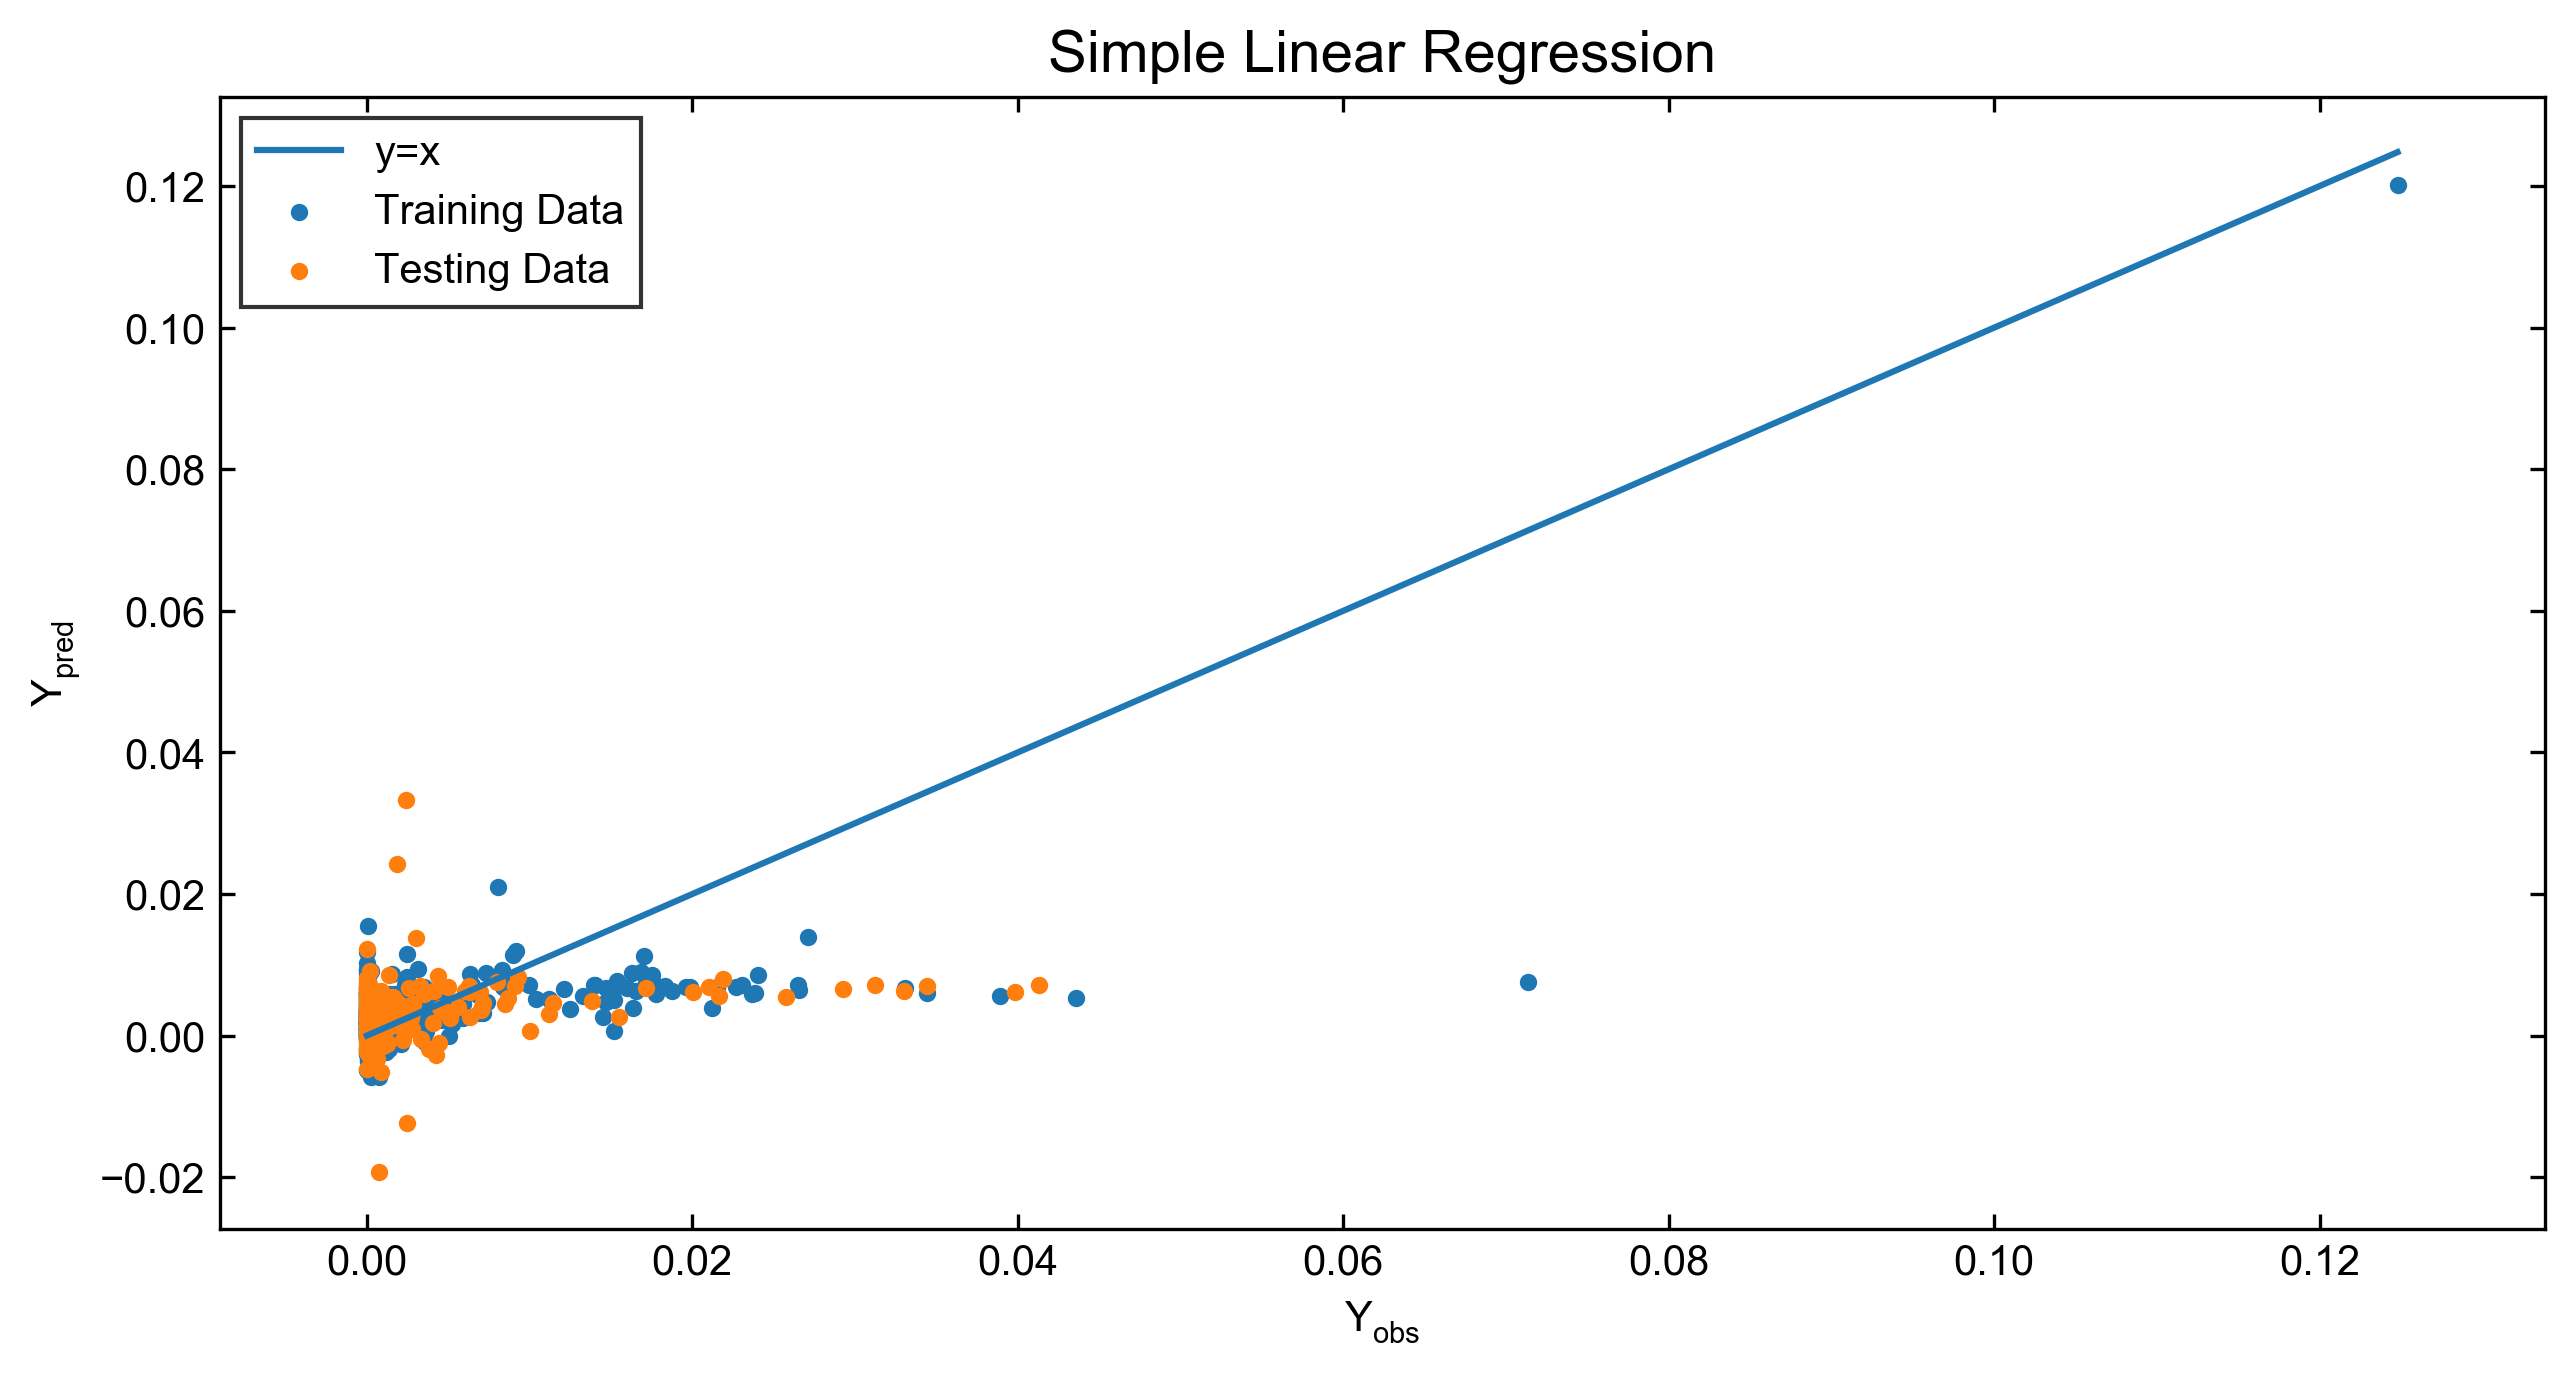

In [11]:
display(Image(filename = 'linreg_traintest_scatter.png'))

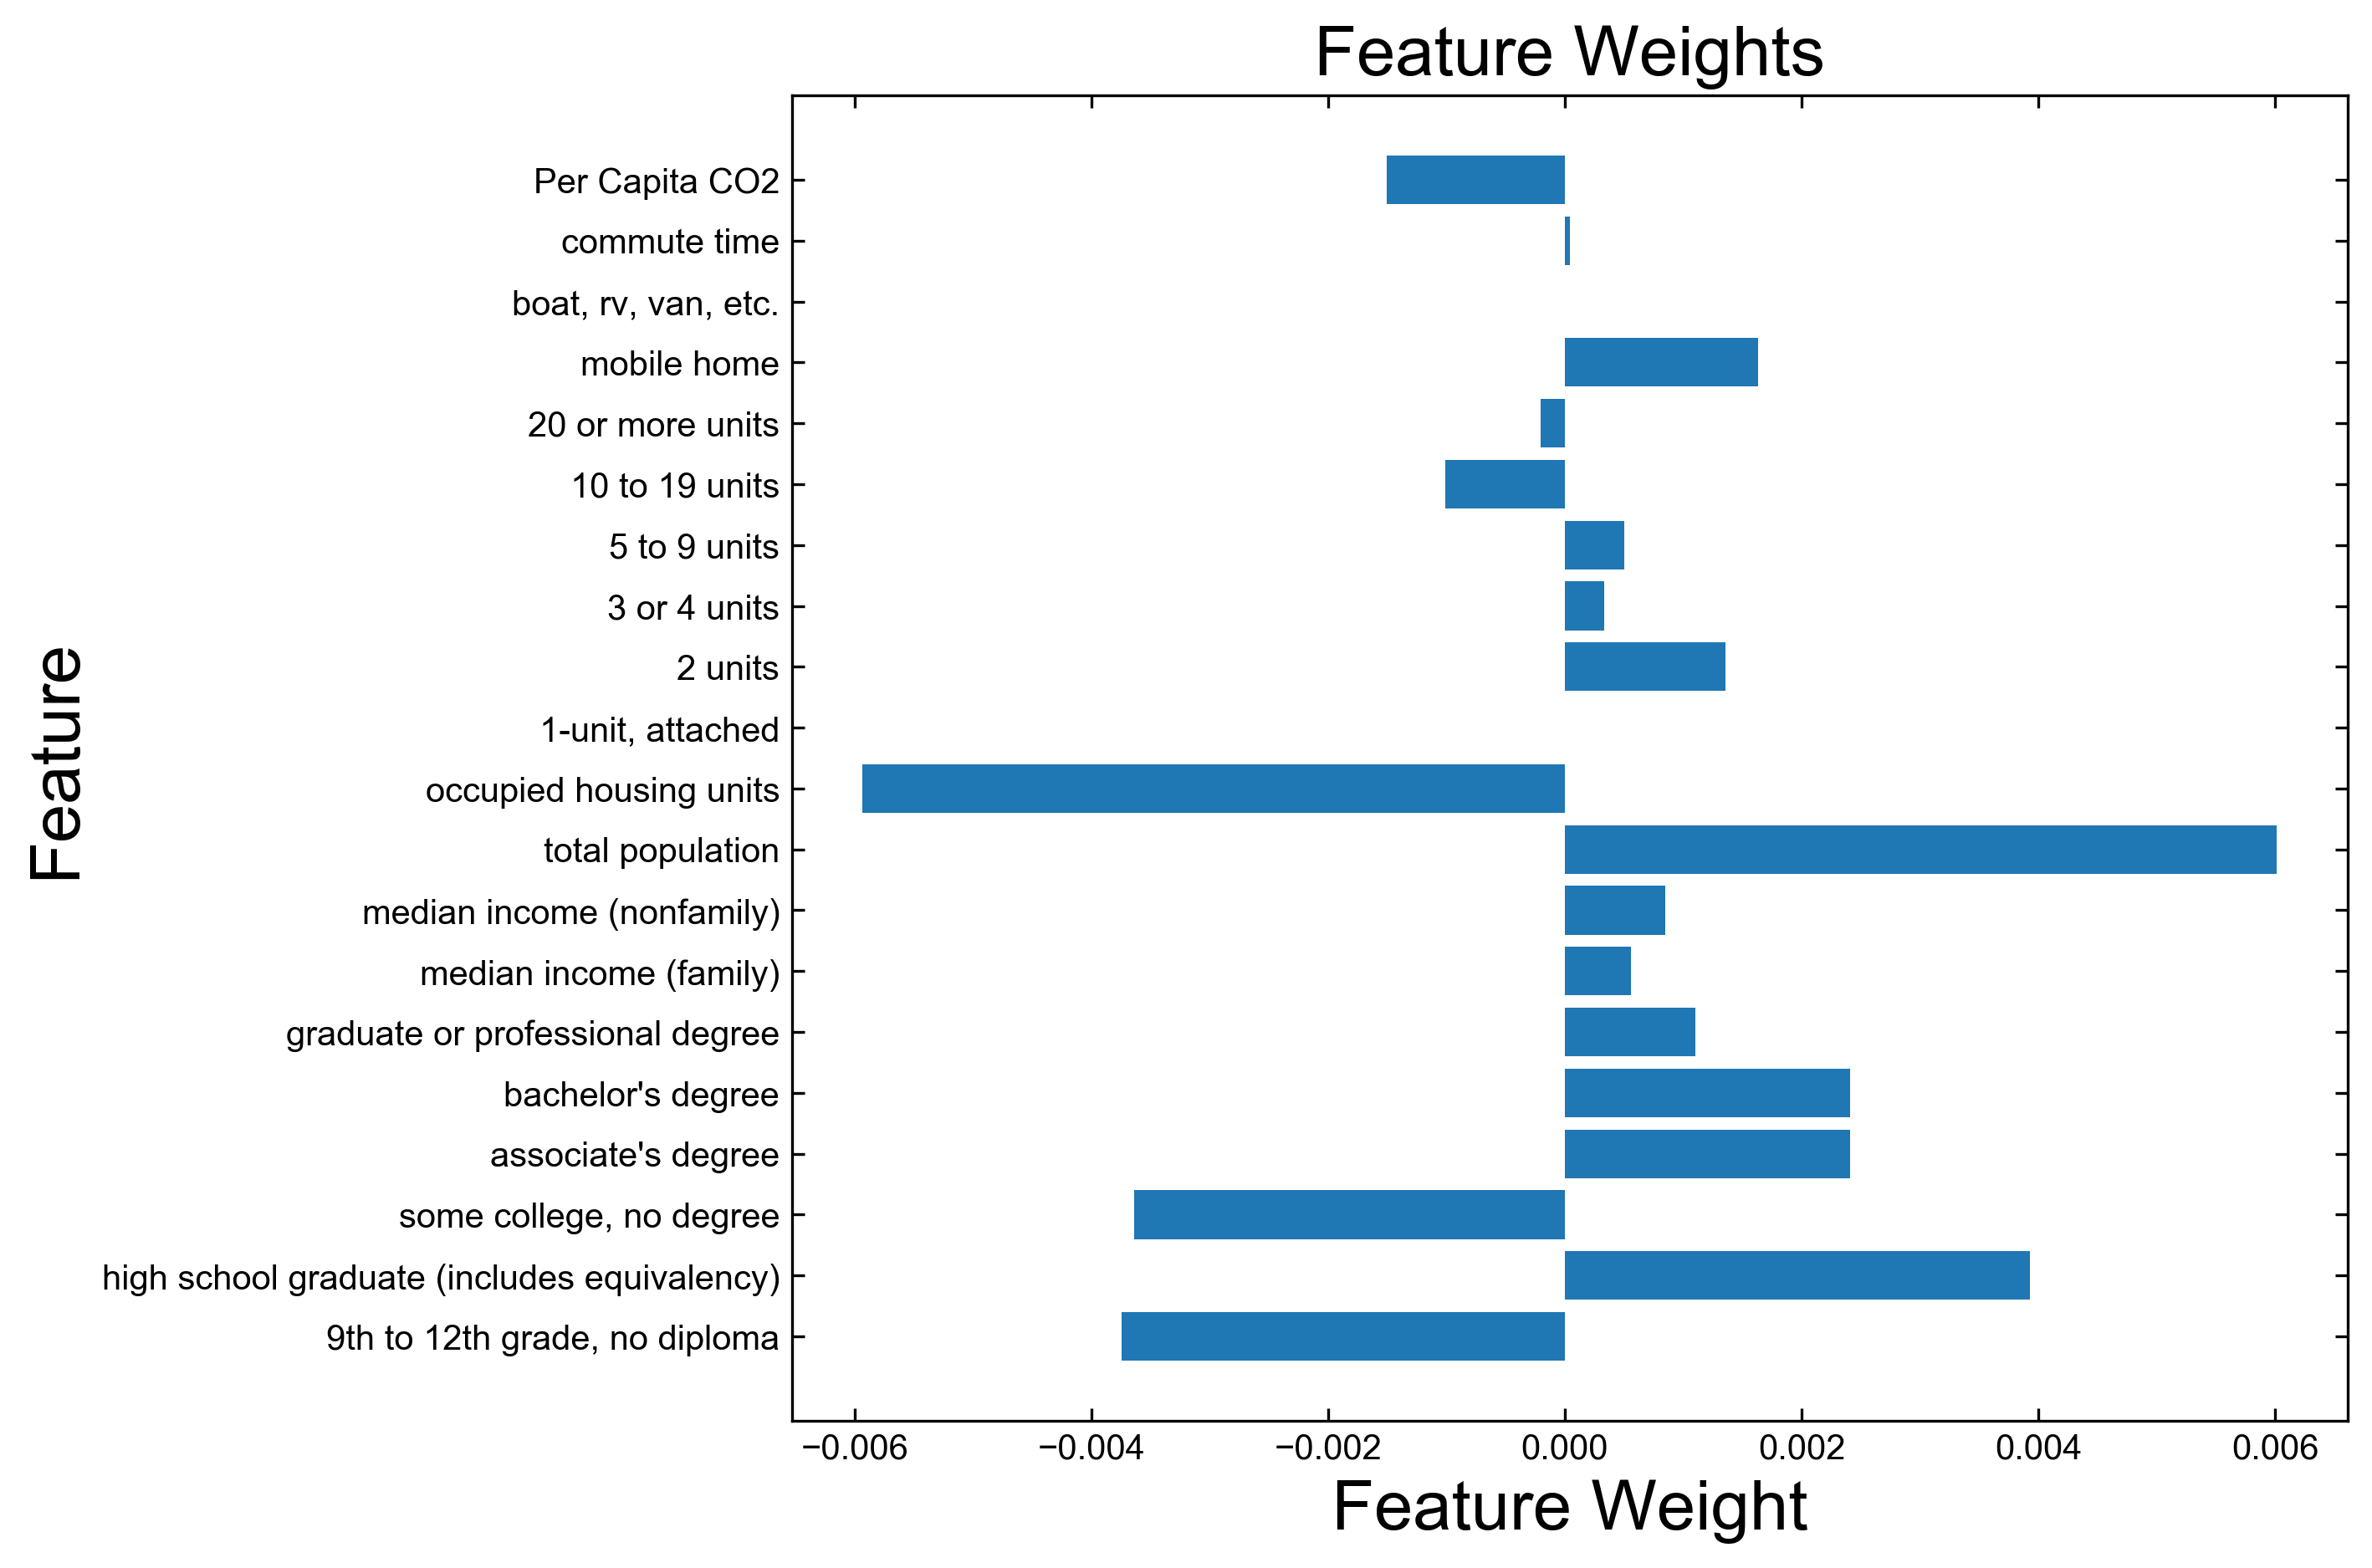

In [12]:
display(Image(filename = 'linearreg_featureweights.png'))

$\;\;\;\;\;\;$We then tried to address the bias in the model through feature engineering. A second linear model was created in which the feature matrix contained all of the original features in addition to the square of each feature. This model suffered from overfitting as seen by the dramatically higher MSE for the testing dataset compared to the training dataset. We decided that randomly engineering features to reduce the bias in the model was not the most effective use of time due to the various possible combinations. Thus, we sought to pursue regularization techniques to quickly determine the strongest predictors of EV usage in a county.

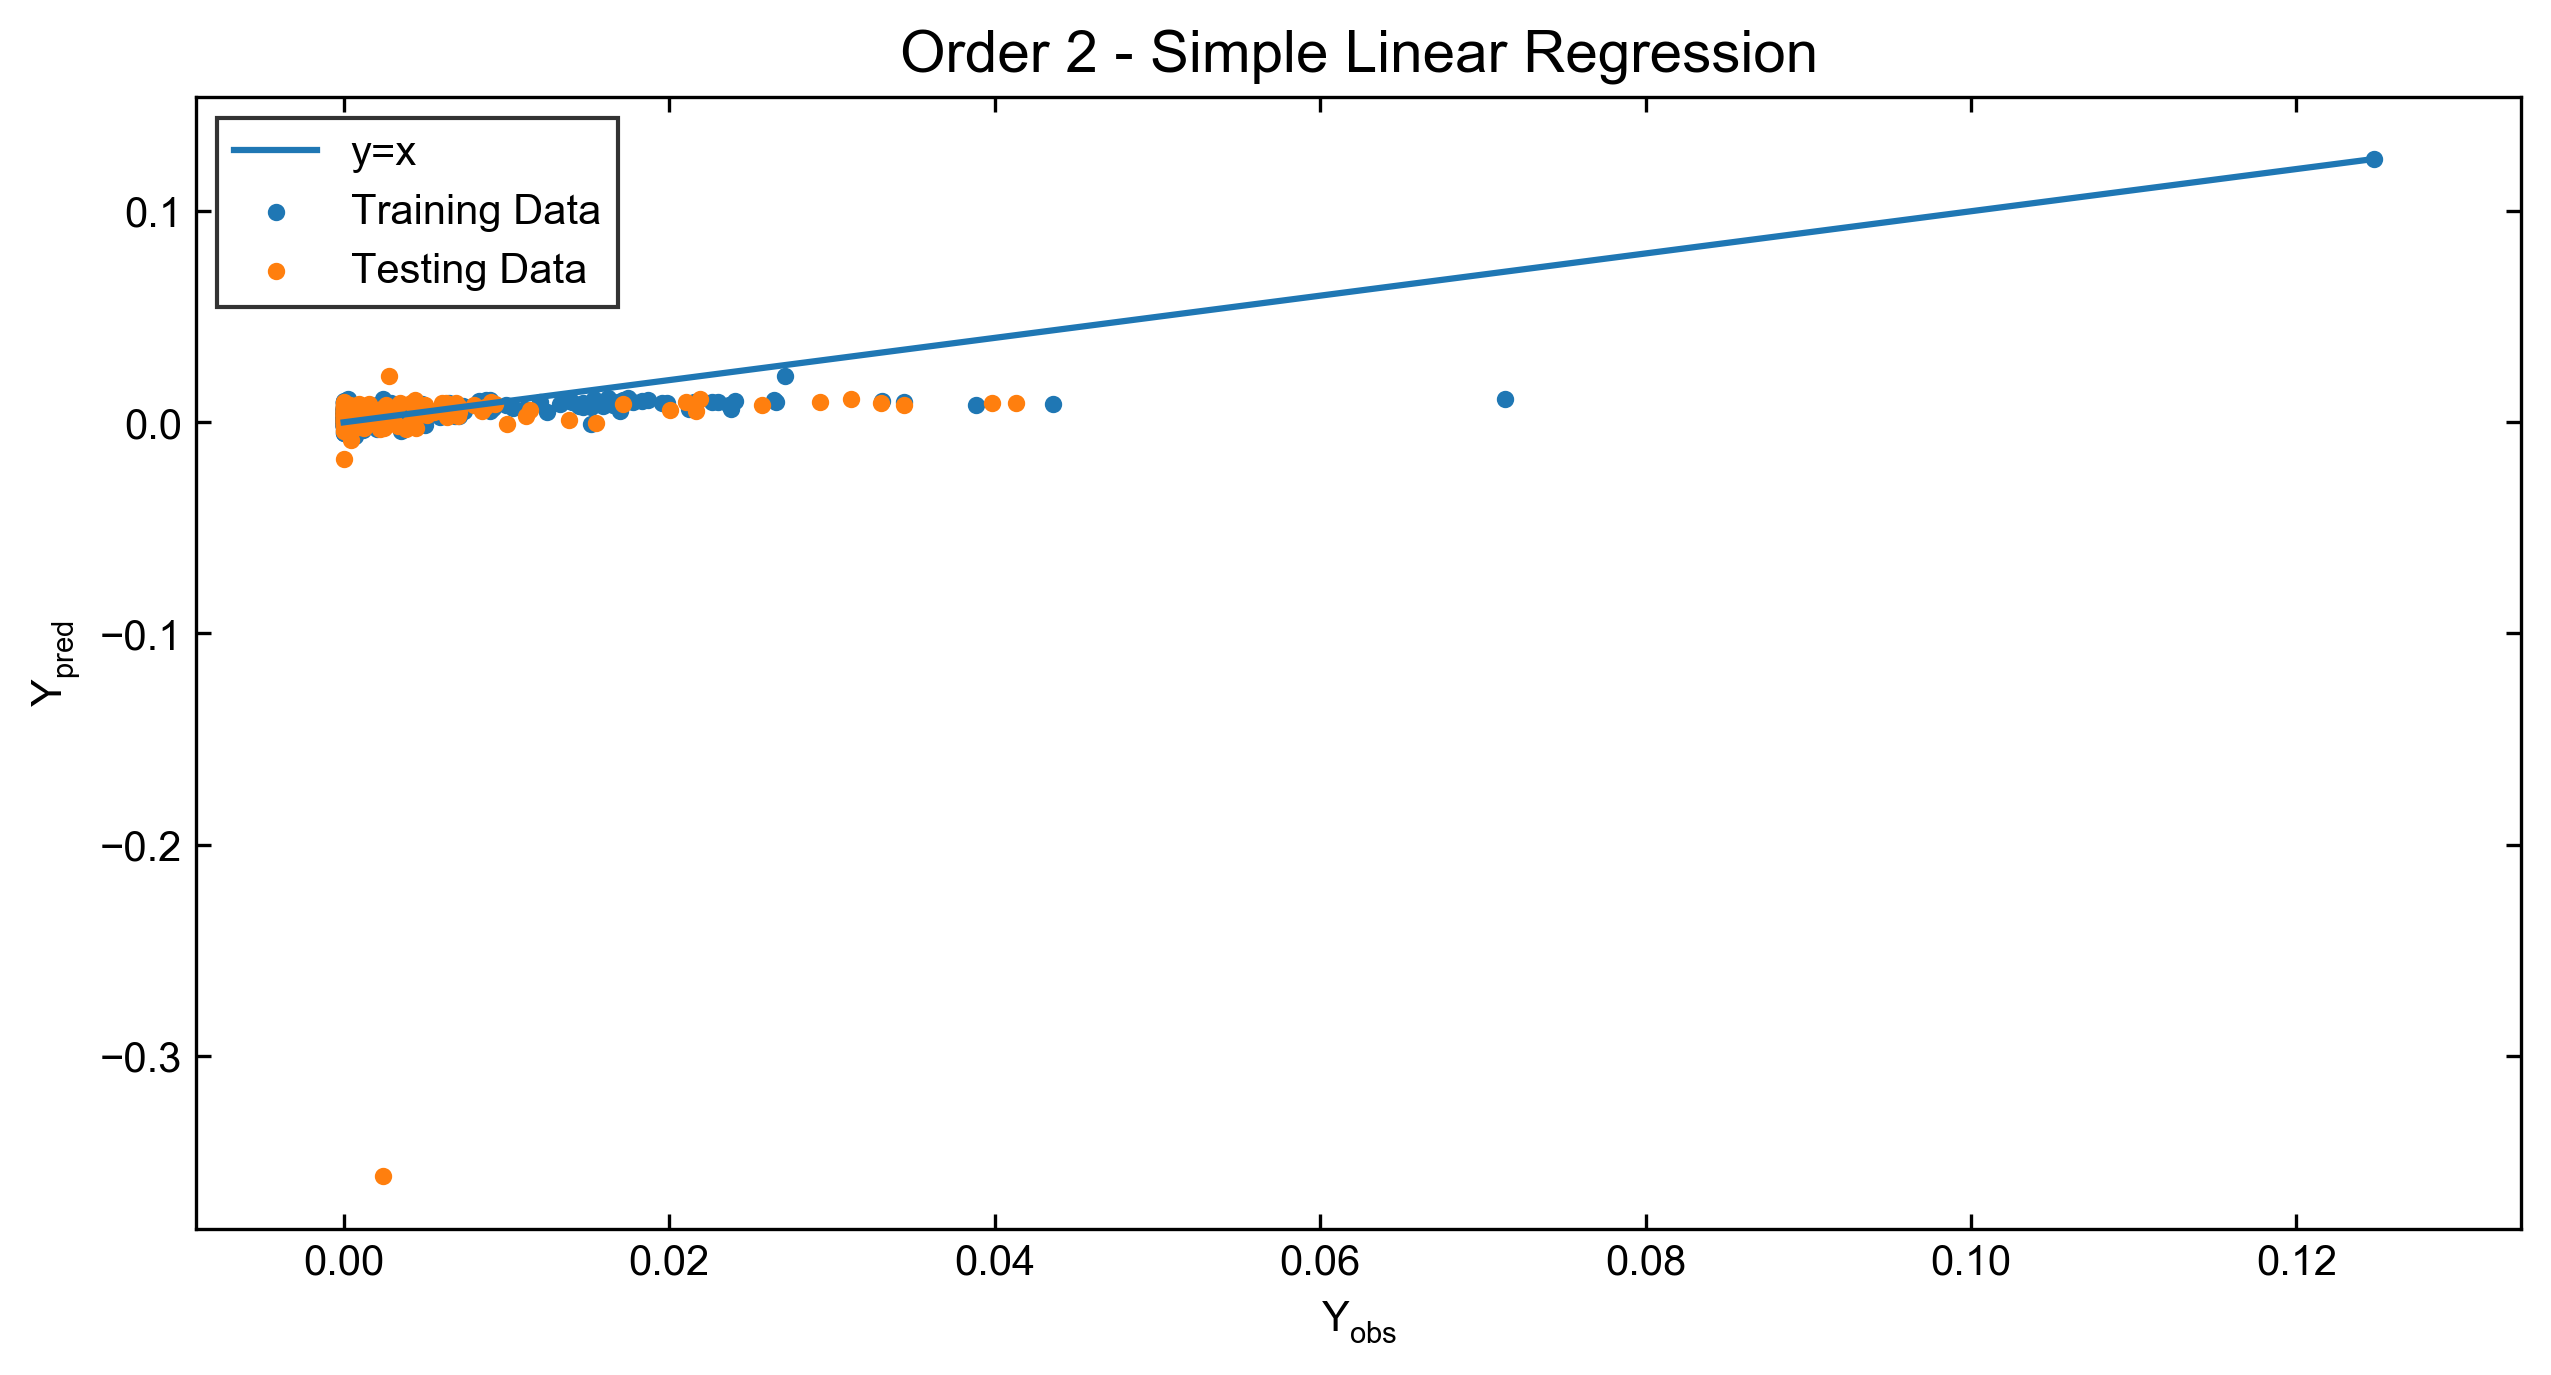

In [13]:
display(Image(filename = 'order2_test_train_scatter.png'))

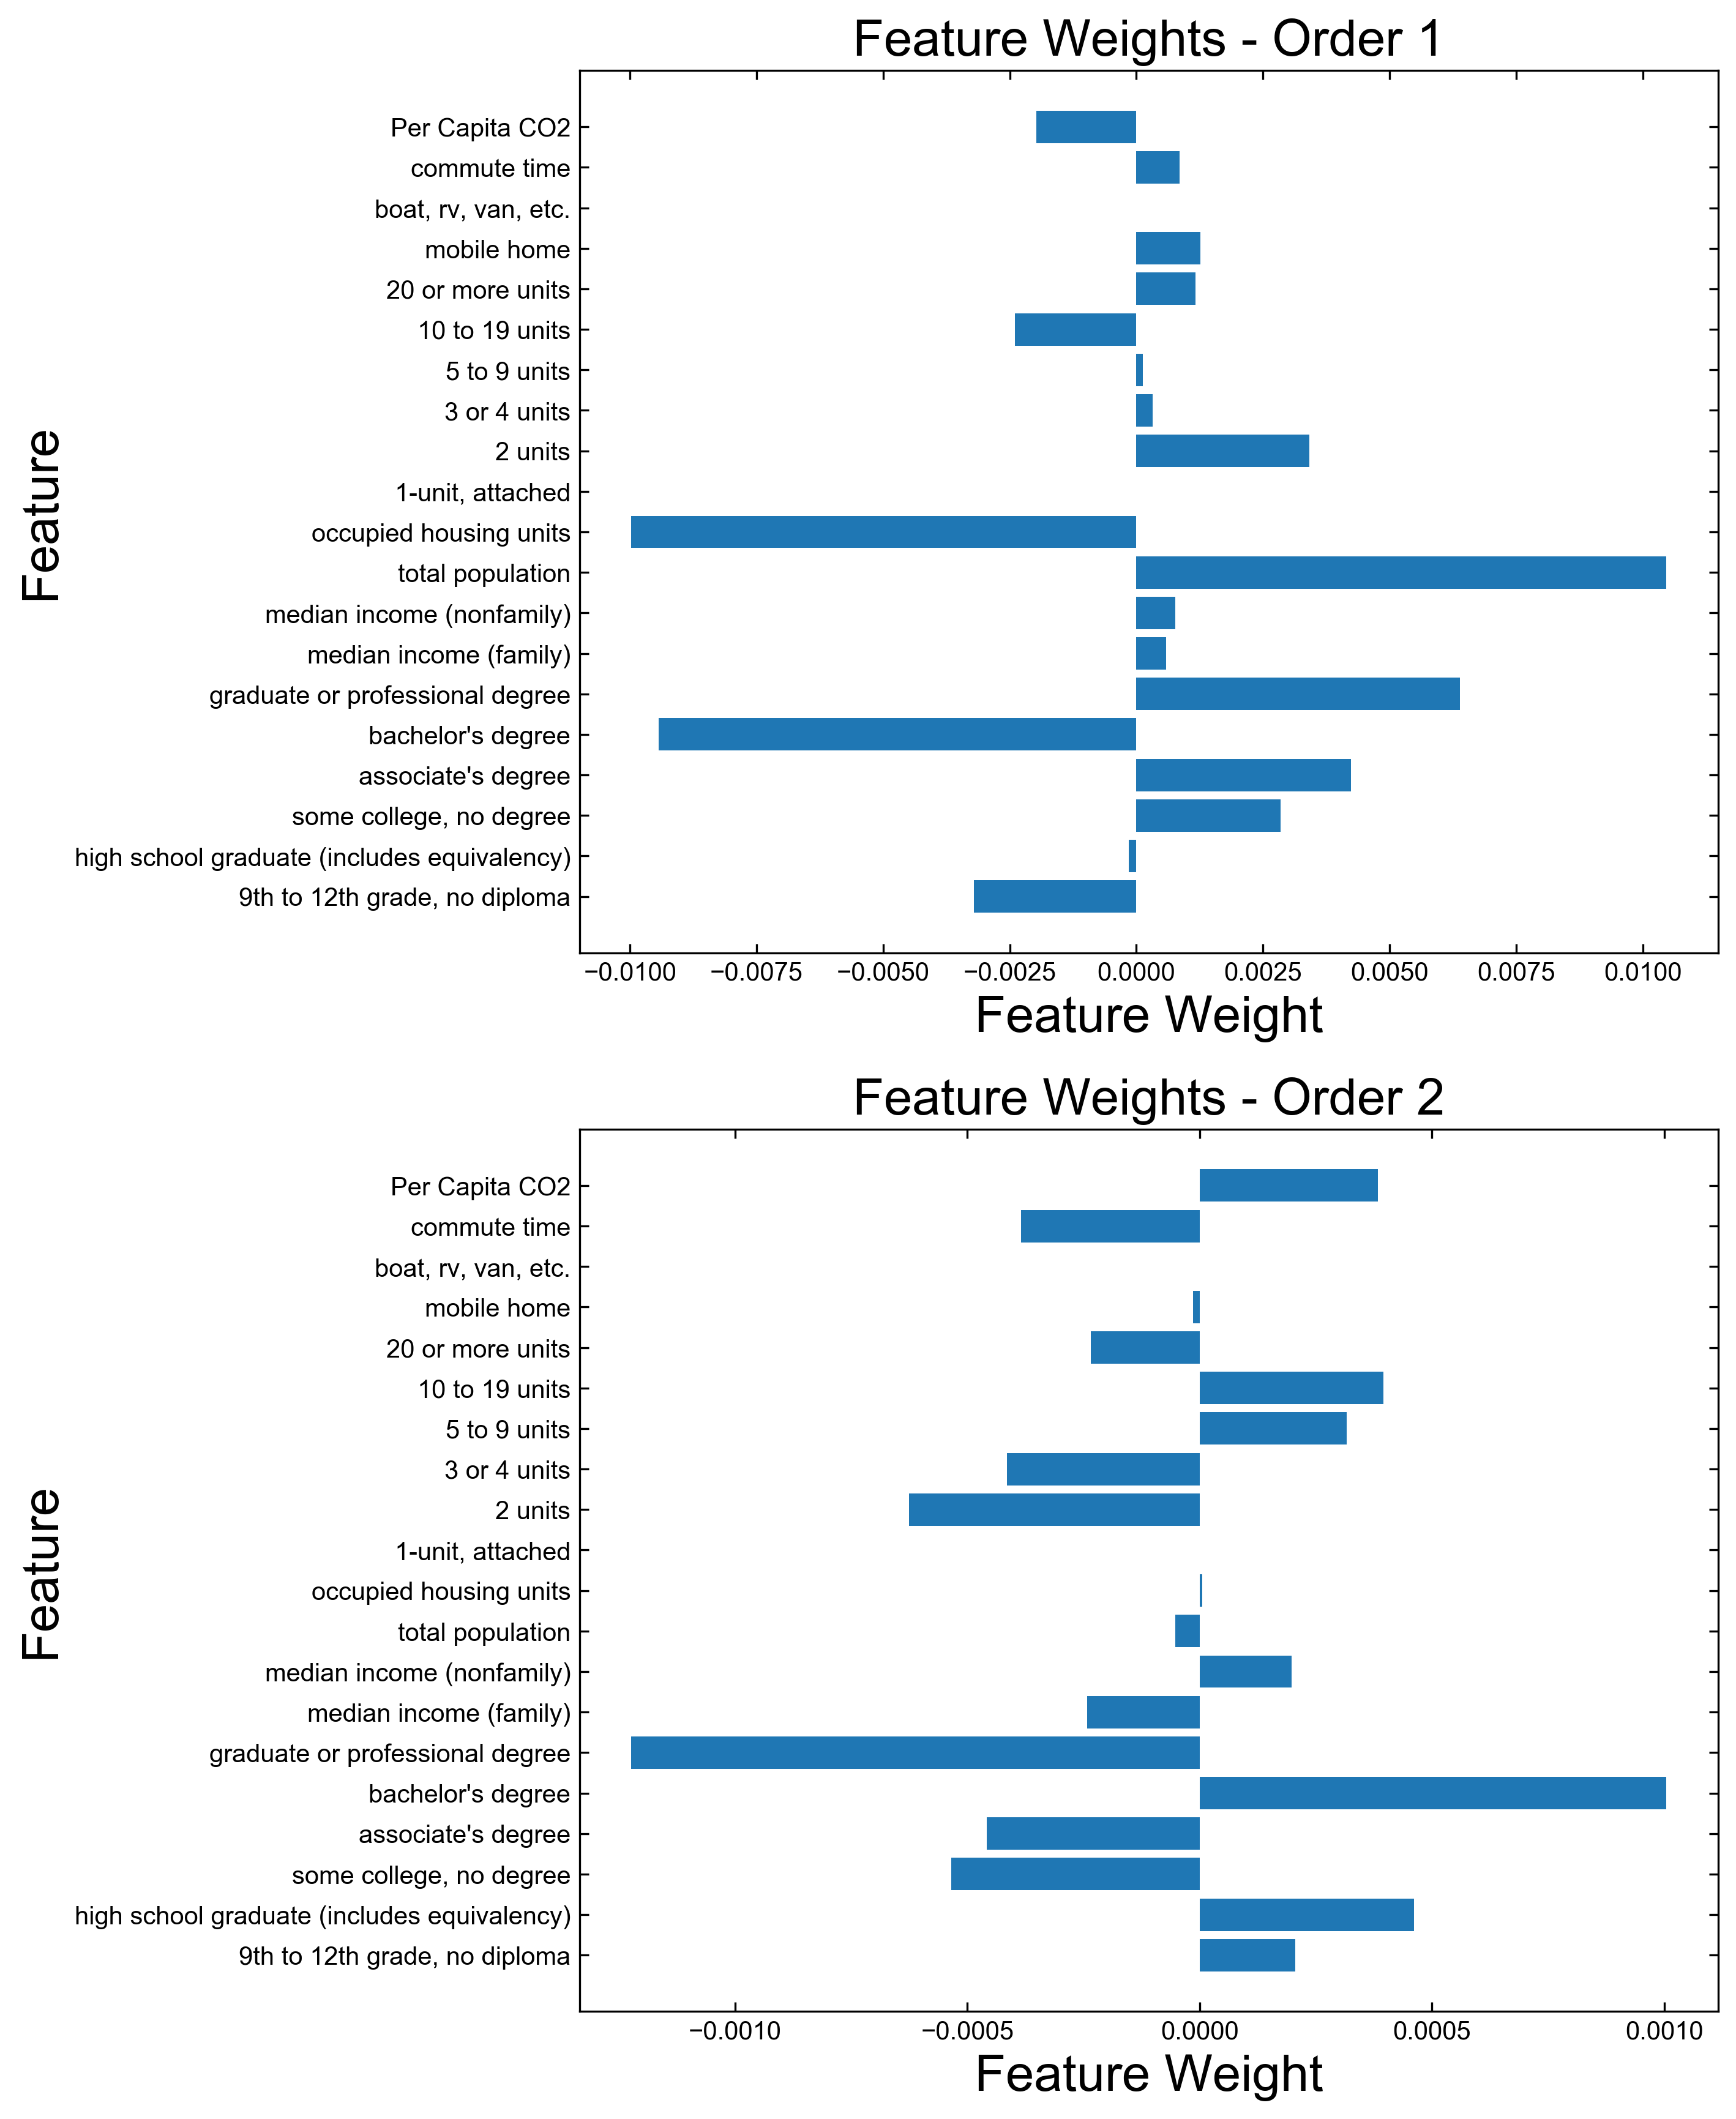

In [14]:
display(Image(filename = 'linreg_weights_order12.png'))

**Ridge Regression**<br>
$\;\;\;\;\;\;$Ridge regression seemed to be a reasonable model choice to try to approach our prediction problem. It is a shrinkage method: the regularization term acts to shrink the value associated with values that are not as important for accurately predicting the value for the target variable. 

To use this method, we first defined an X (features) and y (target variable) matrix. Then we standardized the features using the StandardScaler method. We then used the train_test_split function to split the X and y data into testing and training data. For this model we selected a test size 0.25; a value chosen somewhat arbitrarily (based on previous class examples). 

We then initialized and fit the model on the X and y training data with a typical value of 1 for alpha. We then plotted the values of the coefficients to get a general sense of which carried more/less importance. 


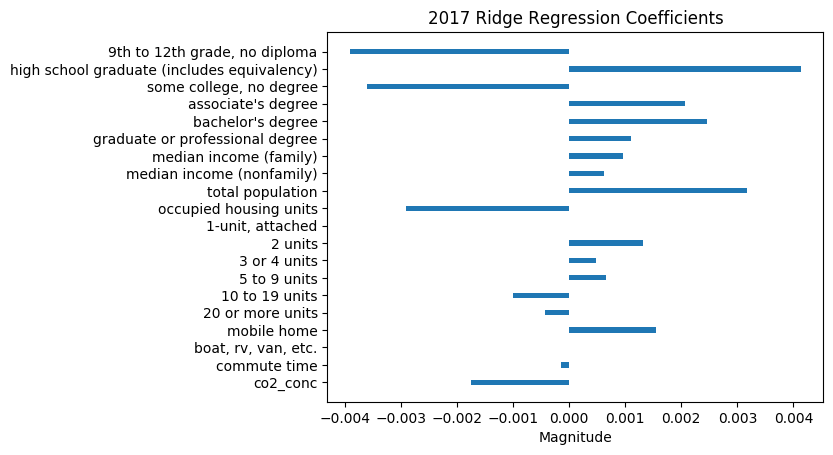

In [15]:
display(Image(filename='ridge_coef2017.png'))

However, we then wanted to see if 1 was an appropriate value for alpha for our model. We created a list of alpha values between 1e-2 and 1e9, all varying by a singular increasing order of magnitude. We calculated the mean squared error for each of these values using our Ridge model, and it appeared that higher values for alpha yielded slightly lower values for the mean squared error. 

We then cross validated our model by using the cross_validate method from sklearn.model_selection. The parameters we specified include the model we used (Ridge), our X training data, our y training data, the number of folds we wanted (5), scoring = make_scorer(mean_squared_error), and return_estimator = True. The selected the number of folds by trying several different values. At around 10 folds the values for the test mean squared error began to vary by at least an order of magnitude, so we decided to select a smaller number of folds. 


**Random Forest Model**<br>
Next, a random forest regression model was constructed to see how a more complex and different variety of model would perform when applied to these data. A decision tree regressor was fitted as an intermediate step in order to more efficiently tune the two hyperparameters which were specified: the maximum number of features used to compute a split, and the minimum number of samples which constitute a leaf. The remaining decision tree parameters were left unspecified to allow for sufficient variation between the decision trees which would comprise the random forest. These hyperparameters were tuned using five fold cross validation, since this was sufficient to provide rigorous validation without being too computationally expensive. The optimal values of these hyperparameters were 6 (fill in after setting random seed in the final notebook) for the minimum samples in a leaf and 2 for the maximum number of features used to compute a split.

After determining the optimal values for these hyperparameters, a random forest model was trained, and the number of estimators was tuned and determined to be 40, again using 5-fold cross validation. This random forest model gave a test MSE of 2.40e-05. Because of the rigorous cross validation and the low test error, we used this model to predict EV adoption for all counties in the US, including those in which EV registration numbers were not available. The results are illustrated in the map below.

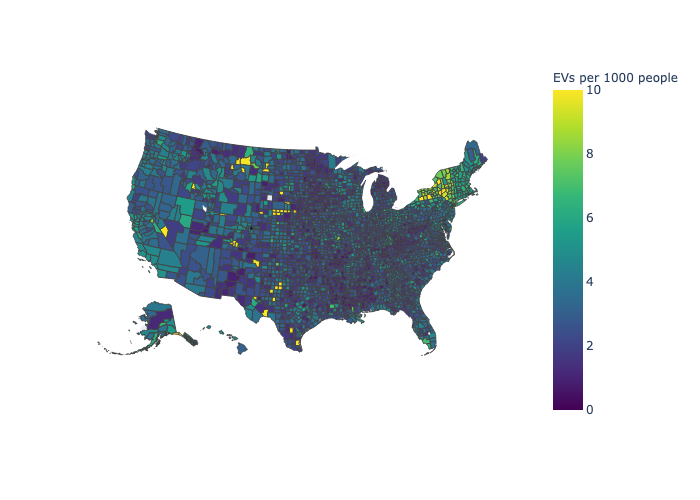

In [18]:
display(Image('2017pred.png'))

**Temporal Prediction**<br>
Our second goal was to predict EV adoption into the future. To do this, we trained 5 separate 
models for 5 different time deltas: 1 year into the future through 5 years into the future. This was accomplished by predicting EV usage in 2018 using 2017, 2016, 2015, 2014, and 2013 as predictor years. Data from the predictor year was used to model EV adoption in 2018. The data for these models include several additional features: the average prices of gasoline, diesel, and electricity during the predictor year; and the number of incentives for purchasing EVs during the predictor year. These features were only available on a national scale, so they were not used in the spatial models. The number of EVs in the predictor year was also included as a feature. Simple linear regression, Ridge regression, and random forest regression were all tested as candidate models, following similar cross-validation procedures for hyperparameter tuning as discussed in previous sections. In this case, ridge regression proved to have the best performance across all five time deltas tested, so this model was used to predict EV adoption into the future across all US Counties. We used the 2017 feature set to predict EV adoption from 2018 through 2022. The predicted change in EV adoption from 2017 values in the counties for which vehicle registration data were availabe is shown below.

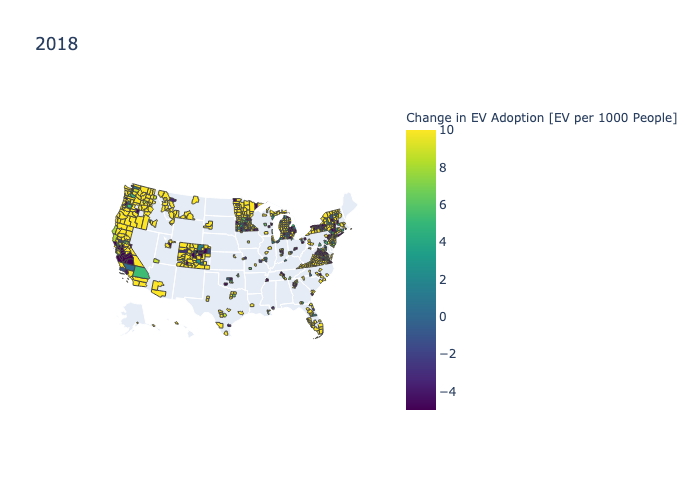

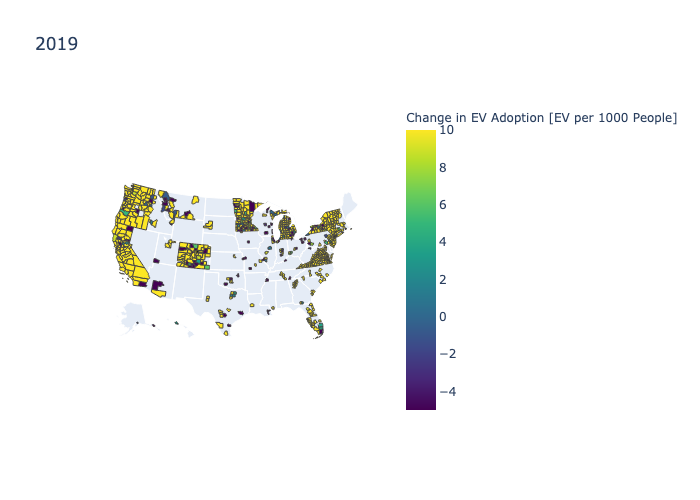

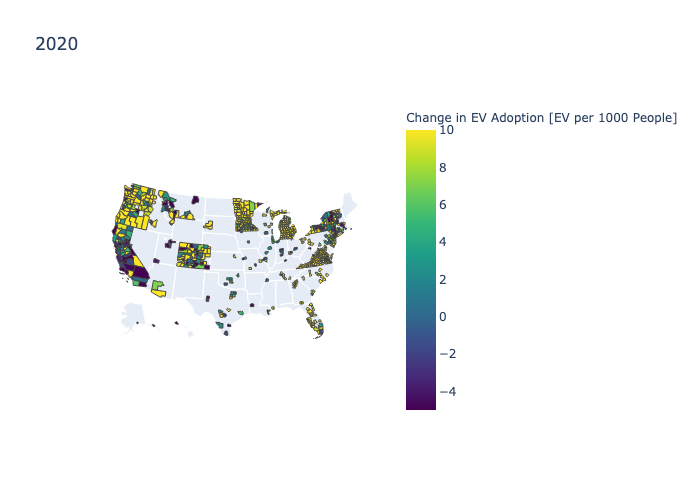

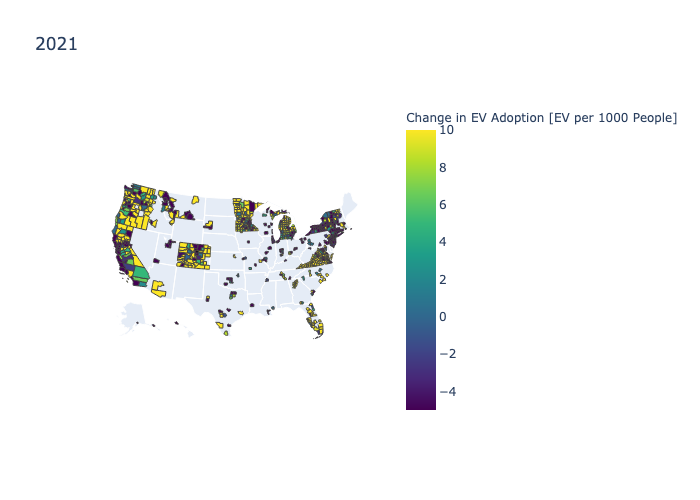

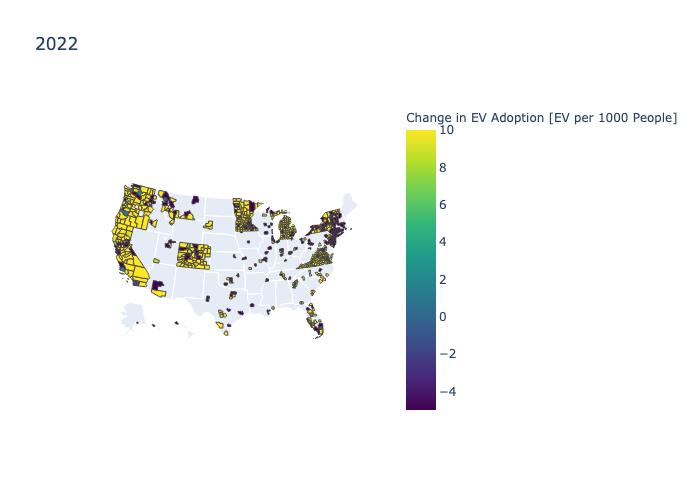

In [19]:
for yr in range(2018,2023):
    display(Image(f'{yr}timepred_change.png'))

## Interpretation and Conclusions

$\;\;\;\;\;\;$There are several barriers to major EV adoption, including, but not limited to the following: cost of ownership, the lack of charging stations, and the heterogeneous distribution of them. Understanding when and where to expect the largest increases in EV adoption to create the infrastructure and incentives to encourage the growth of this sector of transportation is highly dependent upon current knowledge of those same variables. Current information regarding EV ownership in the United States is greatly limited; only a small fraction of states choose to keep records of this data. Even then, it appears the data is compiled by agencies not directly related to other major transportation record keeping (e.g. regional Departments of Motor Vehicles). Instead, at least for the target variable data we used for our project, this information appears to be collected and reported by energy agencies. While these agencies are government related, their collection practices raise concerns about the faithfulness about the data they report. This raises the question of how data related to the number of registered EVs can be properly projected and analyzed. The goal with our project was to address and provide concrete solutions by filling in the gaps; i.e. predicting the number of EVs in different counties, especially in states where it is not already being reported, as well as into the future. 

$\;\;\;\;\;\;$Our models provide highly interpretable results in form of the actual, physical number of registered EVs per capita, making them extremely useful to stakeholders. The map attached below this section shows the values predicted for our model across the United States in 2017. Bright yellow regions indicate a higher number of predicted registered EVs per person, while dark green regions represent low numbers of EVs. To break this down further, this map reveals current EV needs: in yellow counties, there is already a high demand for EV infrastructure, while in green regions there is less of a demand. Stakeholders can use this information to determine where they can benefit the most by targeting regions that most urgently need additional development; information that they otherwise could not obtain because of the issues discussed regarding current reporting practices of EV use. Spatial predictions for a current year can also be used to target EV audiences in terms of marketing for products that may be of interest to this population. 

$\;\;\;\;\;\;$Similar maps can be made with our results showing similar predictions up to five years in the future, and allow companies to develop specific regions for development in the future by installing EV charging stations, for example. However, one problem to note is the indirect impacts these stakeholder actions will have upon our model. Targeting regions of increased number of EVs per capita will further bias those regions in the future in ways that are not currently accounted for in our model.

$\;\;\;\;\;\;$Our random forest model has a low testing error, which is a promising indicator that our model has good generalizability; however, there are certainly limitations to this model. We intentionally chose to focus on demographic and socioeconomic characteristics as predictors of EV adoption, since the relationship between these features and EV adoption have not been well-studied. Because of this, there are certainly variables not included in our model which would be good predictors of EV adoption. It has been previously shown that more technical features, such as the driving performance and safety rating of EVs can greatly influence EV adoption, so combining our feature set with these and other similar features while training the model would improve the predictive performance. Electric vehicles have also become a very politicized issue, so we considered including political affiliation as a variable, but it was difficult to find a single reliable source of this data at the spatio-temporal granularity we required. Thus, we did not include political data in our feature set, but it would be interesting to investigate the relationship between political leanings and EV usage in future work. In general, using a broader feature set to train the model would improve predictive performance. The coefficients for the simple linear regression model and the ridge regularized regularization model were very similar, which suggests that a large number of our chosen features were important predictors. A broader feature set would naturally result in a more effective regularization and feature selection process, and likely lead to better out-of-sample predictive performance. Because EV prevalence is generally low across the country, we believe that our model is very conservative and tends to underestimate EV usage. This is especially true when it comes to the temporal prediction.

$\;\;\;\;\;\;$Our temporal models had significantly higher test MSE than our spatial models, which indicates that our temporal models have poorer predictive performance. Simply offsetting the predictor variables from the response variable is a fairly rudimentary way to build a model for prediction across time, so a more sophisticated model will more effectively predict EV usage in the future. For example, it would be interesting to explore the use of time series modelling frameworks, such as an autoregressive integrated moving average (ARIMA) model, to predict the values of our feature variables in future years before using the same spatial model to predict EV adoption using this forecasted feature set. Alternatively, more complex machine learning frameworks, especially neural networks, might also exhibit better temporal predictive performance. 

$\;\;\;\;\;\;$Overall, our model shows that demographic features can be used to predict EV usage at a county-level granularity in the US, but combining this demographic feature set with a more conventionally-used set of features may result in a more accurate model. More sophisticated modelling techniques are required to develop an accurate model for predicting EV usage into the future.


## Appendix

### Appendix A: Links to Code for Models and Cleaning

#### Github Repository

https://github.com/samaygarg/evprediction

#### Data Cleaning Notebooks

https://raw.githubusercontent.com/samaygarg/evprediction/main/cleaning/datacleaning_features.ipynb

https://raw.githubusercontent.com/samaygarg/evprediction/main/cleaning/datacleaning_vehicles.ipynb

https://raw.githubusercontent.com/samaygarg/evprediction/main/cleaning/datacleaning_vehicles.ipynb

https://raw.githubusercontent.com/samaygarg/evprediction/main/data/Rohit%20Data%20Cleaning.ipynb

#### Spatial Prediction Notebooks

https://raw.githubusercontent.com/samaygarg/evprediction/main/final_lasso_new_v2_ciara.ipynb?token=ART7OT27YTKXTKKCRGGTA3S74F5VU

https://raw.githubusercontent.com/samaygarg/evprediction/main/finalproject_samay.ipynb?token=ART7OT4R4FE73PGT2WCDF7S74F52Y

https://raw.githubusercontent.com/samaygarg/evprediction/main/Final_Project_RR.ipynb

#### Temporal Prediction Notebooks

https://raw.githubusercontent.com/samaygarg/evprediction/main/finalproject_samay.ipynb?token=ART7OT4R4FE73PGT2WCDF7S74F52Y